In [169]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import glob
import time
import cv2
%matplotlib inline

In [170]:
# Get image file names
images = glob.glob('./training-data/*/*/*.png')
cars = []
notcars = []
all_cars = []
all_notcars = []

for image in images:
    if 'non-vehicles' in image:
        all_notcars.append(image)
    else:
        all_cars.append(image)

        

y = np.hstack((np.ones(len(all_cars)), np.zeros(len(all_notcars))))
X = all_cars+all_notcars



In [171]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (64, 64, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 64, 64, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [174]:
import keras
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
X_train = paths_to_tensor(X).astype('float32')/255
rand_state = np.random.randint(0, 100)


100%|████████████████████████████████████████████████████████████████████████████| 7325/7325 [00:03<00:00, 2202.94it/s]


In [175]:
x_train, x_test, y_train, y_test = train_test_split(
    X_train, y, test_size=0.2, random_state=rand_state)
  

In [176]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint  
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(64,64,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        18496     
__________

In [178]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])






In [179]:
epochs = 5
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(x_train, y_train, 
          validation_split=0.2,
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=0)


Epoch 00001: val_loss improved from inf to 0.23301, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00002: val_loss improved from 0.23301 to 0.22442, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00003: val_loss improved from 0.22442 to 0.07316, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00004: val_loss improved from 0.07316 to 0.07281, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00005: val_loss did not improve


In [180]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')



In [181]:
car_predictions = []
for i in x_test:
    
    car_predictions.append(model.predict(np.expand_dims(i, axis=0)))


total = 0
for i in range(0,len(car_predictions)):
    if round(car_predictions[i][0][0]) == y_test[i]:
        total = total + 1
test_accuracy = (total/len(car_predictions))*100        
print('Test accuracy: %.4f%%' % test_accuracy)


Test accuracy: 97.1331%


In [182]:
from pyimagesearch.helpers import pyramid
from pyimagesearch.helpers import sliding_window
import argparse
import time
import cv2
from keras.preprocessing import image   
# construct the argument parser and parse the arguments

final = []
# load the image and define the window width and height
imaged = cv2.imread("./test_series/series4.jpg")
(winW, winH) = (128, 64)


for (x, y, window) in sliding_window(imaged, stepSize=10, windowSize=(winW, winH)):
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
            continue
        clone = imaged.copy()
        clone = cv2.resize(clone[y:y+winH,x:x+winW], (64,64)).astype('float32')/255
        pre = model.predict(np.expand_dims(clone, axis=0))
        if pre[0][0] == 1.0:
                final.append({
                    "x" :x,
                    "y":y,
                    "winH" : winH,
                    "winW": winW,
                    "pred" : pre[0][0]
                })   
print(final)        

[{'x': 830, 'y': 400, 'winH': 64, 'winW': 128, 'pred': 1.0}, {'x': 820, 'y': 410, 'winH': 64, 'winW': 128, 'pred': 1.0}, {'x': 830, 'y': 410, 'winH': 64, 'winW': 128, 'pred': 1.0}, {'x': 800, 'y': 420, 'winH': 64, 'winW': 128, 'pred': 1.0}, {'x': 820, 'y': 420, 'winH': 64, 'winW': 128, 'pred': 1.0}, {'x': 830, 'y': 420, 'winH': 64, 'winW': 128, 'pred': 1.0}, {'x': 820, 'y': 430, 'winH': 64, 'winW': 128, 'pred': 1.0}, {'x': 830, 'y': 430, 'winH': 64, 'winW': 128, 'pred': 1.0}]


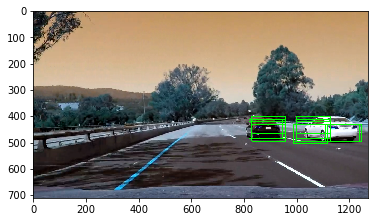

In [168]:
clone = imaged.copy()
for i in final:
    cv2.rectangle(clone, (i['x'], i['y']), (i['x'] + i['winW'], i['y'] + i['winH']), (0, 255, 0), 2)
plt.imshow(clone)    

In [185]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [186]:
def detectcars(imaged):
    (winW, winH) = (128, 64)
    for (x, y, window) in sliding_window(imaged, stepSize=10, windowSize=(winW, winH)):
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
            continue
        clone = imaged.copy()
        clone = cv2.resize(clone[y:y+winH,x:x+winW], (64,64)).astype('float32')/255
        pre = model.predict(np.expand_dims(clone, axis=0))
        if pre[0][0] == 1.0:
                final.append({
                    "x" :x,
                    "y":y,
                    "winH" : winH,
                    "winW": winW,
                    "pred" : pre[0][0]
                })  
        clone = imaged.copy()
    for i in final:
        cv2.rectangle(clone, (i['x'], i['y']), (i['x'] + i['winW'], i['y'] + i['winH']), (0, 255, 0), 2)
    return clone             

In [188]:
from collections import deque
history = deque(maxlen = 8)
history = deque(maxlen = 8)
output = 'test_result.mp4'
clip = VideoFileClip("test_video.mp4")
video_clip = clip.fl_image(detectcars)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_result.mp4
[MoviePy] Writing video test_result.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [23:08<00:36, 36.53s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_result.mp4 

Wall time: 23min 9s
